In [67]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.compat.v1.train import AdamOptimizer


In [89]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "../../PlantVillage"
CHANNELS = 3
AUTOTUNE = tf.data.AUTOTUNE

In [69]:
#funtion for spliting the dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [70]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed =123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 2152 files belonging to 3 classes.


In [71]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


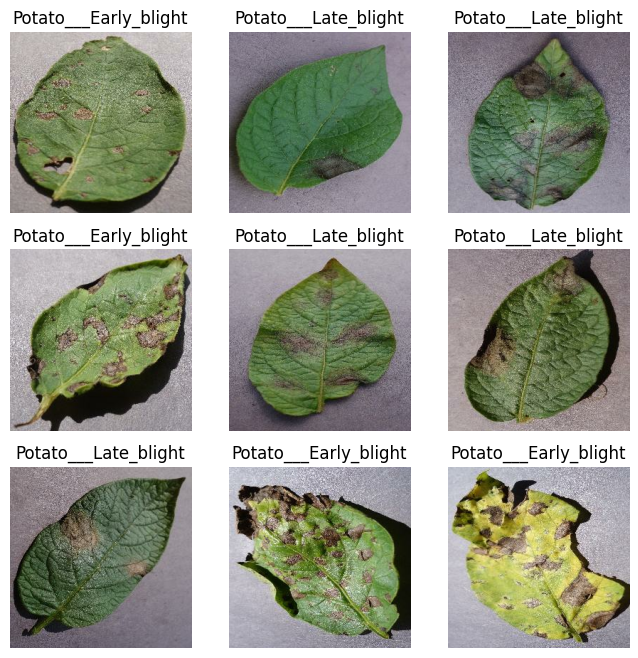

In [72]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [73]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [74]:
train_ds = train_ds.cache().shuffle(999).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(999).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(999).prefetch(buffer_size=AUTOTUNE)

In [75]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255), #to converet the tensors into numpys 
])

In [76]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [77]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [78]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [79]:
#model summary 
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [80]:
model.compile(
    optimizer=AdamOptimizer(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [81]:
#traing 
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
54/54 [==============================] - 39s 689ms/step - loss: 0.8651 - accuracy: 0.5522 - val_loss: 0.7035 - val_accuracy: 0.7188
Epoch 2/30
54/54 [==============================] - 45s 826ms/step - loss: 0.6062 - accuracy: 0.7465 - val_loss: 0.4997 - val_accuracy: 0.7708
Epoch 3/30
54/54 [==============================] - 42s 782ms/step - loss: 0.4219 - accuracy: 0.8292 - val_loss: 0.3965 - val_accuracy: 0.8125
Epoch 4/30
54/54 [==============================] - 42s 770ms/step - loss: 0.3568 - accuracy: 0.8509 - val_loss: 0.2893 - val_accuracy: 0.8698
Epoch 5/30
54/54 [==============================] - 41s 752ms/step - loss: 0.3883 - accuracy: 0.8445 - val_loss: 0.2552 - val_accuracy: 0.8906
Epoch 6/30
54/54 [==============================] - 46s 857ms/step - loss: 0.2566 - accuracy: 0.8908 - val_loss: 0.2521 - val_accuracy: 0.9167
Epoch 7/30
54/54 [==============================] - 38s 698ms/step - loss: 0.2708 - accuracy: 0.8897 - val_loss: 0.2880 - val_accuracy: 0.8438

In [82]:
#testing
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)



[INFO] Calculating model accuracy
8/8 [==============================] - 2s 172ms/step - loss: 0.2407 - accuracy: 0.9180


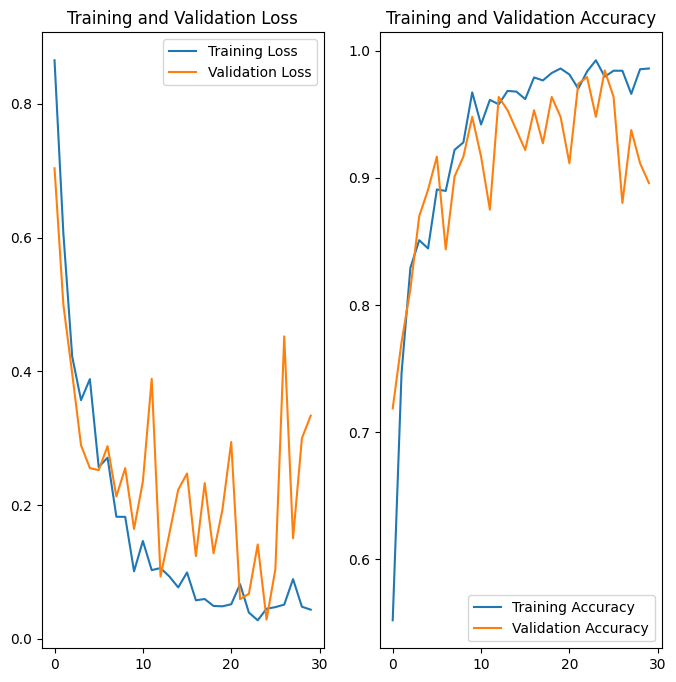

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
actual label Potato___Late_blight
1/1 [==============================] - 0s 246ms/step
predicted label Potato___Late_blight


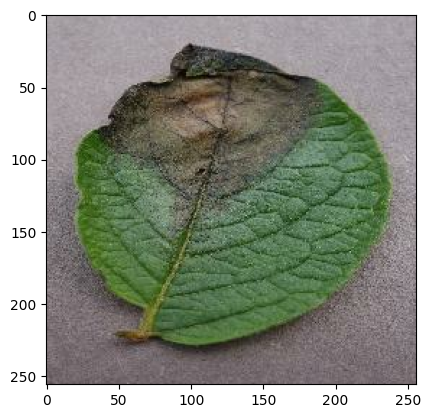

In [84]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("actual label", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label", class_names[np.argmax(batch_prediction[0])])

In [85]:
import os
import glob
from tensorflow import keras

os.makedirs("../models", exist_ok=True)

existing_models = glob.glob("../models/*")
model_version = max([int(os.path.basename(i)) for i in existing_models] + [0]) + 1

model_path = os.path.join("../models", str(model_version))

# Create a Keras optimizer (e.g., Adam)
optimizer = keras.optimizers.Adam()

# Compile the model with the Keras optimizer
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Save the model
model.save(model_path, save_format='tf')  # or 'h5' depending on your preference


INFO:tensorflow:Assets written to: ../models\2\assets


INFO:tensorflow:Assets written to: ../models\2\assets


In [86]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


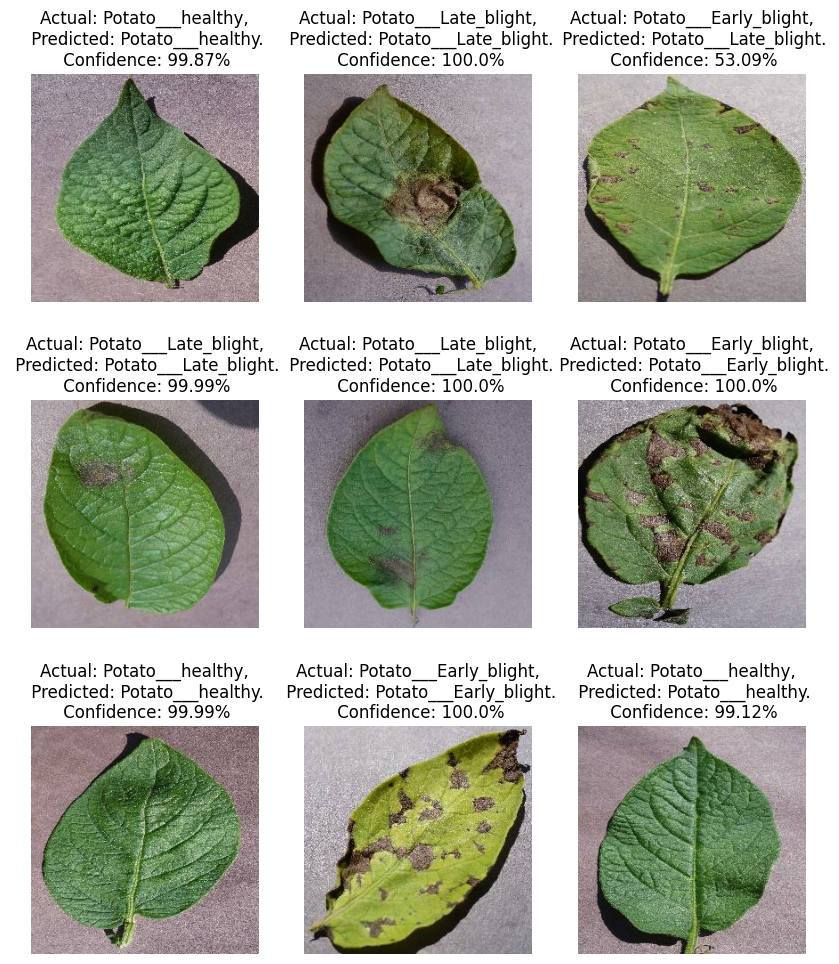

In [59]:
plt.figure(figsize=(10, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")